<a href="https://colab.research.google.com/github/stevenhirsch/Evaluating-Skeletal-Muscle-Mitochondrial-Capacity-with-NIRS-data/blob/main/NIRS_Data_Colab_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NIRS Code to Noninvasively Evaluate Muscle Mitochondrial Capacity

Physiology researchers and other applied scientists are interested in assessing muscle mitochondrial function to understand muscle health and disease. Usually, this assessment is performed by surgically removing muscle tissue samples, and mitochondrial enzymes are used as a proxy for mitochondrial function.

In addition to being an invasive and costly procedure, another limitation of this method is that mitochondrial function would be inferred from limited samples. A solution to these limitations is to leverage advances in Near-Infrared Optical Spectroscopy (NIRS) technology. These devices have been used to measure various physiological markers such as muscle blood flow and perfusion, muscle oxygen consumption, and muscle oxygenation. You can also find this technology in most modern smart watches or other fitness wearables. NIRS works by measuring the oxygen-dependent absorption of NIR light by haemoglobin/myoglobin.

One specific use of NIRS technology in the physiology literature is to assess the recovery of muscle oxygenation following exercise as a proxy for its oxidative capacity. Briefly, experimental protocols will typically consist of two measurements of resting oxygen muscle consumption after inflating a blood pressure cuff to occlude the artery. Muscle oxygen consumption is then calculated as the slope of the measured deoxygenated haeomoglobin signal during arterial occlusion using linear regression. After resting measurements, recovery kinetics are assessed following a short duration constractions (to increase muscle oxygen consumption). The recovery kinetics of muscle oxygen consumption following the brief exertion are assessed using a series of short-duration arterial occlusions (e.g., 5s on/5s off for first 5 occlusions, and then the next five occlusions may use 7s on/7s off) and post-exercise muscle oxygen consumption is calculated at each occlusion using, again, linear regression. 

After collecting this post-exercise muscle oxygen consumption data (which is usually normalized with an ischaemic calibration & corrected for blood volume), an exponential function is fit to determine an index of mitochondrial oxidation capacity. The function is as follows: 

$y = (end-\Delta)\times e^{-kt}$

where $y$ is the relative muscle oxygen consumption during the arterial occlusion, $end$ is the muscle oxygen consumption immediately following exercise, $\Delta$ is the change in muscle oxygen consumption from rest to end-exercise, $t$ is time, and $k$ is the fitting rate constant (the index of mitochondrial respiratory capacity).

The following code automates these analyses using Python. It assumes that you have an excel file exported from your NIRS software (like in the example provided) and automatically exports plots of the fitting rate constant (k_value_plot.pdf), total haeomoglobin and myoglobin (tHB.pdf), oxygenation haeomoglobin and myoglobin (o2Hb.pdf), deoxygenated haemoglobin and myoglobin (HHb.pdf), ischaemically calibrated o2Hb and HHb, blood-volume corrected o2Hb and HHb, as well as csv files containing the average o2Hb and HHb slopes at rest (slopes_resting.csv) and a timeseries containing blood-volume corrected and ischaemically calibrated o2Hb and HHb data (corrected_data.csv).

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sampleData.xlsx to sampleData (1).xlsx


In [ ]:
import io
df = pd.read_excel(list(uploaded)[0], skiprows=range(0,43), usecols = "A:G")

## Data Cleaning & Functions

In [ ]:
#forward fill event names
df.ffill(axis = 0, inplace= True)
#Calculation of intermediate variables
df['bv_correction'] = df.O2Hb/(df.O2Hb + df.HHb)
df['corrected_o2Hb'] = df.O2Hb-(df.tHb*(1-df.bv_correction))
df['corrected_HHb'] = df.HHb-(df.tHb*df.bv_correction)
df['ical_o2Hb'] = (df.corrected_o2Hb-min(df.corrected_o2Hb))/(max(df.corrected_o2Hb) - min(df.corrected_o2Hb))*100
df['ical_HHb'] = (df.corrected_HHb-min(df.corrected_HHb))/(max(df.corrected_HHb) - min(df.corrected_HHb))*100

In [ ]:
def remove(string): 
    return string.replace(" ", "") 
df.Event = remove(df.Event.str)

In [ ]:
# Function to calculate the 02Hb slope
# possesses flexibility to accommodate to **any** occlusion cycle time
def evaluate_o2Hb_slope(data, num_trials):
    slope_o2Hb = np.array([])
    slope_HHb = np.array([])
    new_time = np.array([])
    time_cal = data[data.Event == "C1"].iloc[0]['TIME (s)']
    for i in range(num_trials):
        value = "C" + str(i*2+1)
        intdf = data[data.Event == value]
        ### O2Hb MVO2
        slope_1, intercept, r_value, p_value, std_err = stats.linregress(intdf['TIME (s)'], intdf.ical_o2Hb)
        slope_o2Hb = np.append(slope_o2Hb, slope_1)
        ### HHb MVO2
        slope_2, intercept, r_value, p_value, std_err = stats.linregress(intdf['TIME (s)'], intdf.ical_HHb)
        slope_HHb = np.append(slope_HHb, slope_2)
        current_time = data[data.Event==value].iloc[0]['TIME (s)'] - time_cal
        new_time = np.append(new_time, current_time)

    new_df = pd.DataFrame({
        'time': new_time,
        'corrected_slope': slope_o2Hb,
        'slope_HHb': slope_HHb
    })

    return new_df

In [ ]:
# Creates default function to fit an exponential model
def create_exp_model(x, a, c, d):
    return a * np.exp(-c * x) + d

In [ ]:
# Using the same starting points to initialize exponential model as in Terrence et al.'s code.
StartPoint = [(5, 0.0333, 0.3)]
def get_k_value(data, sp, num_trials= 20, ):
    data2 = evaluate_o2Hb_slope(data, num_trials)
    ### For O2Hb Signal
    popt, pcov = curve_fit(create_exp_model, data2.time, data2.corrected_slope, p0 = sp, maxfev = 4000)
    o2hb_rate_constant = popt[1]*60
    o2hb_time_constant = 1/o2hb_rate_constant
    yy = create_exp_model(data2.time, *popt)

    ### For HHb Signal
    popt_2, pcov_2 = curve_fit(create_exp_model, data2.time, data2.slope_HHb, p0 = sp, maxfev = 4000)
    hhb_rate_constant = popt_2[1]*60
    hhb_time_constant = 1/hhb_rate_constant

    yy_2 = create_exp_model(data2.time, *popt_2)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(data2.time, data2.corrected_slope, color= 'red', marker= 'D', label= 'O2HB Tc= ' + str(round(o2hb_time_constant,2)) + 'min')
    ax.scatter(data2.time, data2.slope_HHb, color= 'blue', marker='o', label= 'HHB Tc= ' + str(round(hhb_time_constant,2)) + 'min')
    ax.plot(data2.time, yy, color= 'red', linestyle= '--')
    ax.plot(data2.time, yy_2, color= 'blue', linestyle= '--')
    ax.text(0.7, 0.075, 'k = ' + str(round(o2hb_rate_constant,2)) + 'min$^{-1}$', transform=ax.transAxes)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('mV$_{O2}$')
    ax.legend(loc= 'upper right')
    plt.savefig('k_value_plot.pdf', dpi=150)

In [ ]:
# Function to calculate the (resting) 02Hb slope
def evaluate_resting_o2Hb_slope(data):
    slope_o2Hb = np.array([])
    slope_HHb = np.array([])
    new_time = np.array([])
    time_cal = data[data.Event == "A1"].iloc[0]['TIME (s)']
    for i in range(4):
        value = "A" + str(i*2+1)
        intdf = data[data.Event == value]
        ### O2Hb MVO2
        slope_1, intercept, r_value, p_value, std_err = stats.linregress(intdf['TIME (s)'], intdf.ical_o2Hb)
        slope_o2Hb = np.append(slope_o2Hb, slope_1)
        ### HHb MVO2
        slope_2, intercept, r_value, p_value, std_err = stats.linregress(intdf['TIME (s)'], intdf.ical_HHb)
        slope_HHb = np.append(slope_HHb, slope_2)
        current_time = data[data.Event==value].iloc[0]['TIME (s)'] - time_cal
        new_time = np.append(new_time, current_time)

    new_df = pd.DataFrame({
        'O2HB Slope': slope_o2Hb,
        'HHb Slope': slope_HHb
    })

    return new_df

## Processing & Plots

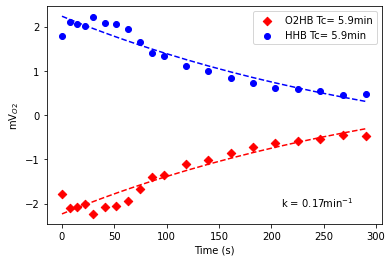

In [ ]:
get_k_value(df, StartPoint)

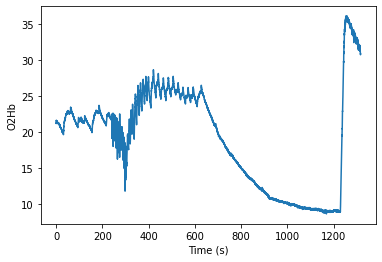

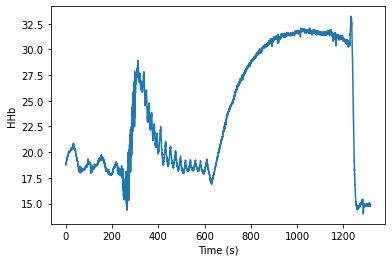

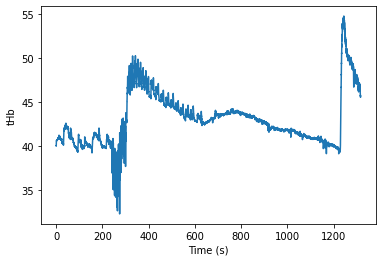

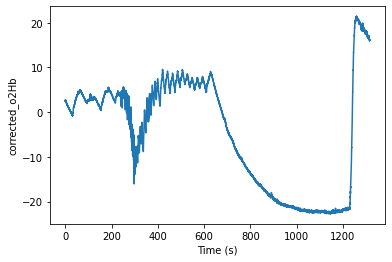

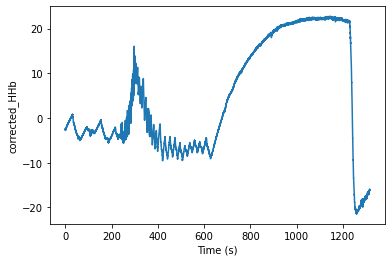

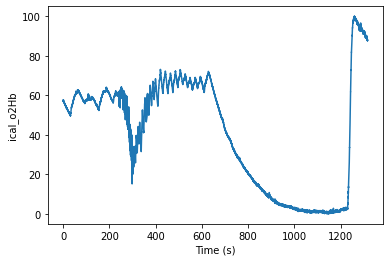

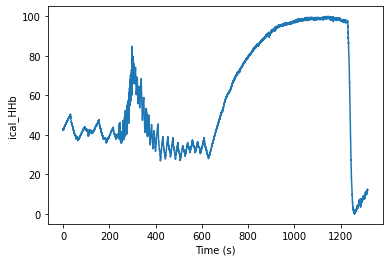

In [ ]:
figs = ['O2Hb', 'HHb', 'tHb', 'corrected_o2Hb', 'corrected_HHb', 'ical_o2Hb', 'ical_HHb']
for var in figs:
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(df['TIME (s)'], df[var])
  ax.set_xlabel('Time (s)')
  ax.set_ylabel(var)
  plt.savefig(str(var)+'.pdf', dpi=150)

In [ ]:
df_corrected = df[['TIME (s)', 'corrected_o2Hb', 'corrected_HHb', 'ical_o2Hb', 'ical_HHb', 'Event']]
df_corrected = df_corrected[df_corrected['Event'].str.contains("C")]
df_corrected.to_csv('corrected_data.csv')

In [ ]:
# Descriptive stats of 4 "resting" trials
rest_df = evaluate_resting_o2Hb_slope(df)
rest_df.describe().to_csv('slopes_resting.csv')

## Export

In [ ]:
from zipfile import ZipFile
filenames = ['HHb.pdf', 'O2Hb.pdf', 'corrected_HHb.pdf', 'corrected_data.csv','corrected_o2Hb.pdf', 
             'ical_HHb.pdf','ical_o2Hb.pdf','k_value_plot.pdf','slopes_resting.csv','tHb.pdf']
# create a ZipFile object
zipObj = ZipFile('processed_data.zip', 'w')
# Add multiple files to the zip
for i in filenames:
  zipObj.write(i)
# close the Zip File
zipObj.close()
# Download Zip
files.download('processed_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>